In [2]:
import matplotlib as mpl
from Datasets import * 

import numpy as np
import matplotlib.pyplot as plt
np.set_printoptions(precision=3, linewidth=120)
from LiteModels import DeepLite
from Datasets import *

from MMD.mmd import MMD_3_Sample_Test
import h5py as h5
from tqdm import trange
from scipy.misc import imresize
import seaborn as sns
import pandas as pd

from nuts import nuts
from nuts.emcee_nuts import NUTSSampler
from maf import experiments as ex

%matplotlib inline

Using cuDNN version 6021 on context None
Mapped name None to device cuda: GeForce GTX 1080 Ti (0000:84:00.0)


## Load data

In [3]:
seed = 0
noise_std = 0.05
dname = "redwine"
p = load_data(dname,D=2,  N=5000, valid_thresh=0.0, noise_std = noise_std, seed=seed, itanh=False, whiten=True)
#p = load_data("ring",D=2, data_args={"nring":3, "sigma":0.2}, N=5000, valid_thresh=0.0, noise_std = noise_std, seed=seed, itanh=False, whiten=True)

p_clean = load_data(dname,D=2, N =5000, valid_thresh=0.0, noise_std = 0.0, seed=seed, itanh=False, whiten=True)
p_noise = load_data(dname,D=2, N =5000, valid_thresh=0.0, noise_std = noise_std, seed=seed, itanh=False, whiten=True)

D = p.D
    
plot_size=8
ngrid = 100

In [57]:
# visualise data

#df = pd.DataFrame(p.sample(1000))
#sns.pairplot(df,plot_kws=dict(s=4, alpha=1.0, linewidth=0))

# Training the model
If want to retrain, set `gpu_count=1` if you have a gpu

In [8]:
dl_model = DeepLite(p, npoint=300, nlayer=3, nneuron=20, init_log_lam=-3, points_std=0.0, keep_prob=1.0, init_weight_std=1.0, noise_std=0.0,
                    points_type="opt", log_lam_weights=-6, step_size=1e-3, mixture_kernel=False, init_log_sigma=np.linspace(0,1,1), base=True,
                    niter=5000, ntrain=100, nvalid=100, patience=30, seed=seed,gpu_count=0)
#res = dl_model.fit(niter=5000, ntrain=100, nvalid=100,ntest=500, nbatch=1, patience=30)
dl_model.load()

INFO:tensorflow:Restoring parameters from ckpts/R_D11_l3_nd20_np300_nt100_nv100_pto_ss10_ni5000_n05_k10_m0_b1_p30_nk1_s00.ckpt


# visualize some variables in the model

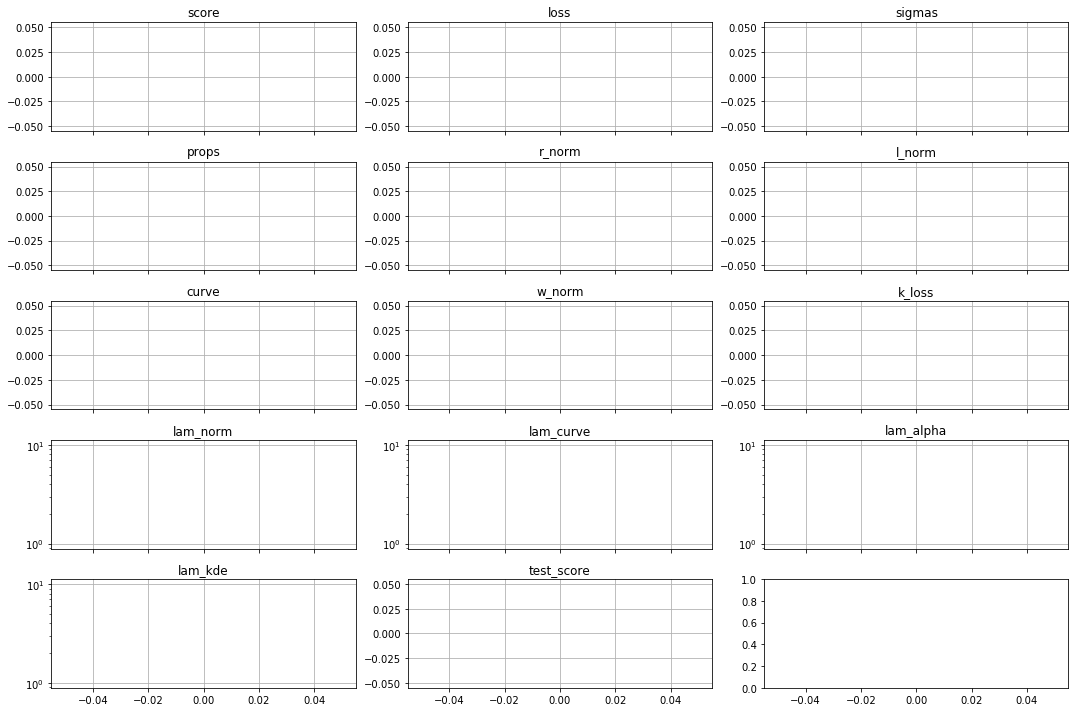

In [9]:
fig, axes = plt.subplots(5,3,figsize=(15,10), sharex=True)

axes = axes.flatten()
res = dl_model.state_hist

for ki, k in  enumerate(res):
    ax = axes[ki]
    ax.plot(res[k])
    ax.set_title(k)
    if "lam" in k: 
        ax.set_yscale("log")
    ax.grid("on")
        
        
fig.tight_layout()

In [10]:
# final fit of alphas. Better do it on cpu so have to redefine the model (set True) and tell it gpu_count = 0
#dl_model.set_test(True, 0) 
dl_model.fit_alpha(5000)

In [11]:
# evaluate log likelihood, repeat to see whether reliable
for i in range(2):
    dl_model.logZ = None
    dl_model.estimate_normaliser(n=2*10**6, batch_size=10**5, std=p.test_data.std()*1.0)
    test_loglik = dl_model.estimate_data_lik(p.test_data, batch_size=p.test_data.shape[0])
    print test_loglik.mean()

-13.5441089634
-13.5553526509


# Visualise density of two dimensions conditioned on others dimensions being zeros

In [25]:
def get_grid(r, i, j, cond):


    grid = np.meshgrid(r,r)

    grid = np.stack(grid,2)
    grid = grid.reshape(-1,2)
    
    num_point = len(grid)
    grid_cond = np.tile(cond[None,:], [num_point, 1])
    
    grid_cond[:,i] = grid[:,0]
    grid_cond[:,j] = grid[:,1]
    return grid_cond

(-5.0, 5.0)

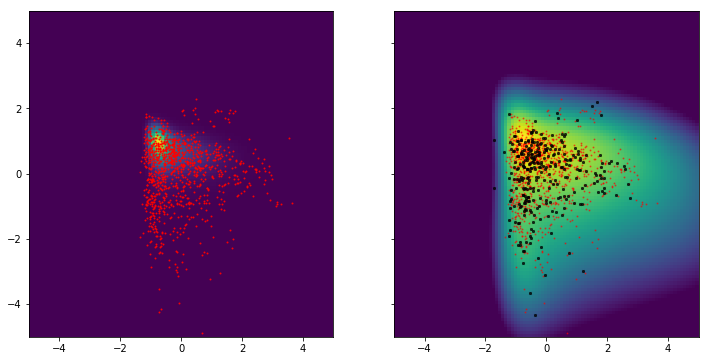

In [35]:
idx_i, idx_j = 0,2

ngrid = 100
eval_grid = np.linspace(-5,5,ngrid)

cond_values = np.zeros(p.D)
epsilon = 1.5

eval_points = get_grid(eval_grid, idx_i, idx_j, cond_values)


fv = dl_model.fun_multiple(eval_points)
gv = dl_model.grad_multiple(eval_points)

#fv = p.logpdf_multiple(eval_points)
#gv = p.grad_multiple(eval_points)
#fv = kde.score_samples(eval_points)


gv = gv.reshape(ngrid, ngrid, p.D)
gint = 5


fig, axes = plt.subplots(1,2, figsize=(12,6), sharex=True, sharey=True)

ax = axes[0]

logpdf = fv.copy() - fv.max()
pdf = np.exp(logpdf - logpdf.max())
pdf /= pdf.sum()
ax.pcolor(eval_grid, eval_grid, pdf.reshape(ngrid, ngrid))
ax.scatter(p.data[:1000,idx_i], p.data[:1000,idx_j], 1, color="r", alpha=0.9)


ax = axes[1]
points_val = dl_model.sess.run(dl_model.points)
ax.pcolor(eval_grid, eval_grid, logpdf.reshape(ngrid, ngrid), vmin=-20)
ax.scatter(p.data[:1000,idx_i], p.data[:1000,idx_j], 1, color="r", alpha=0.5)
ax.scatter(points_val[:1000,idx_i], points_val[:1000,idx_j], 5, color="k", alpha=0.8, vmin=1, marker="x")
#ax.quiver(eval_grid[::gint], eval_grid[::gint], gv[::gint,::gint,0], gv[::gint,::gint,1], scale=500)

dim = range(p.D)
dim.remove(idx_i)
dim.remove(idx_j)
#idx_in_range = np.all( (p.test_data[:,dim]<cond_values[dim]+epsilon) &  (p.test_data[:,dim]>cond_values[dim]-epsilon), axis=1)
#data_in_range = p.test_data[idx_in_range]

#plt.scatter(data_in_range[:,i], data_in_range[:,j], 15, color="b")

ax.set_xlim(eval_grid.min(),eval_grid.max())

ax.set_ylim(eval_grid.min(),eval_grid.max())

In [59]:
# Visualize kernel

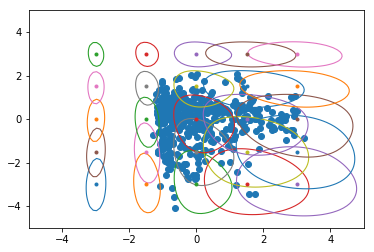

In [63]:
grid_points = get_grid(np.linspace(-3,3,5), idx_i,idx_j,np.zeros(p.D))
grid_data_one=np.linspace(-5,5,100)
grid_data   = get_grid(grid_data_one, idx_i,idx_j,np.zeros(p.D))

for ki in range(len(dl_model.ops["kernel_grams"])):
    
    kernel_vals = dl_model.sess.run(dl_model.ops["kernel_grams"][ki], feed_dict={dl_model.test_points: grid_points, dl_model.test_data: grid_data})

    for i in range(kernel_vals.shape[0]):
        kv = kernel_vals[i]
        plt.contour(grid_data_one, grid_data_one, kv.reshape(100,100), [0.8], vmin=kv.min(), vmax=kv.max(), colors="C%d"%(i%9), linewidths=[(0.1*(ki+1)**2+1)])
        plt.plot(grid_points[i,idx_i], grid_points[i,idx_j], ".",  color="C%d"%(i%9))
plt.scatter(p.test_data[:,idx_i], p.test_data[:,idx_j])

# Sampling

In [41]:
nsample = 200
Madapt = 100
delta = 0.7
thin = 5
nchain = 1

def lnprobfn(x):
    x = np.atleast_2d(x)
    return dl_model.fun_multiple(x, batch_size=1)[0]


def gradfn(x):
    x = np.atleast_2d(x)
    return dl_model.grad_multiple(x, batch_size=1)[0]

def lnprobgradfun(x):
    x = np.atleast_2d(x)
    return dl_model.fun_multiple(x, batch_size=1)[0], dl_model.grad_multiple(x, batch_size=1)[0]

samples = []
for i in range(nchain):
    #sampler = NUTSSampler(D, lnprobfn, gradfn)
    #s = sampler.run_mcmc(np.zeros(p.D), nsample*thin/nchain, Madapt, delta)
    s, lnprob, epsilon = nuts.nuts6(lnprobgradfun, nsample*thin/nchain, Madapt, np.zeros(p.D), delta)
    samples.append(s[::thin])
samples = np.concatenate(samples, axis=0)

nuts sampling:   0%|▏                                              | 4/1099 [00:00<00:47, 22.92it/s]

('find_reasonable_epsilon=', 0.25)


nuts sampling: 100%|████████████████████████████████████████████| 1099/1099 [01:08<00:00, 16.09it/s]


# Train maf and sample from it

In [43]:
n_hiddens = 100
n_layers = 5
n_comps = 10

act_fun = 'tanh'
mode = 'random'

maf_data_obj = ex.load_data(dname.lower(), D=p.D, noise_std=noise_std, seed=seed, itanh=False, whiten=True, N=5000)
maf_model = ex.train_maf([n_hiddens]*2, act_fun, n_layers, mode)
#maf_model = ex.train_maf_on_made([n_hiddens]*2, act_fun, n_layers, n_comps, mode)
#maf_data_obj = ex.load_data(dname, noise_std=0.0, seed=seed, itanh=False, whiten=True, N=5000)
#maf_model_clean = ex.train_maf([n_hiddens]*2, act_fun, n_layers, mode)

p.test_data.shape
print maf_model.eval(p.test_data).mean()
maf_samples = maf_model.gen(nsample)

maf/ml/models/mafs.py:56: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  input_order = input_order if input_order == 'random' else made.input_order[::-1]


(500, 11)

# Maf density 

(-5.0, 5.0)

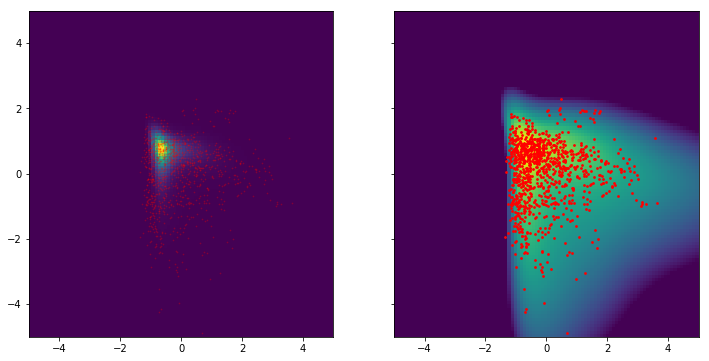

In [64]:
fv = maf_model.eval(eval_points)

fig, axes = plt.subplots(1,2, figsize=(12,6), sharex=True, sharey=True)

ax = axes[0]

logpdf = fv.copy() - fv.max()
pdf = np.exp(logpdf - logpdf.max())
pdf /= pdf.sum()
ax.pcolor(eval_grid, eval_grid, pdf.reshape(ngrid, ngrid))
ax.scatter(p.data[:1000,idx_i], p.data[:1000,idx_j], 1, color="r", alpha=0.2)


ax = axes[1]
ax.pcolor(eval_grid, eval_grid, logpdf.reshape(ngrid, ngrid), vmin=-15)
ax.scatter(p.data[:1000,idx_i], p.data[:1000,idx_j], 3, color="r", alpha=1.0)

dim = range(p.D)
dim.remove(idx_i)
dim.remove(idx_j)
idx_in_range = np.all( (p.test_data[:,dim]<cond_values[dim]+epsilon) &  (p.test_data[:,dim]>cond_values[dim]-epsilon), axis=1)
data_in_range = p.test_data[idx_in_range]
#plt.scatter(data_in_range[:,i], data_in_range[:,j], 15, color="b")

ax.set_xlim(eval_grid.min(),eval_grid.max())
ax.set_ylim(eval_grid.min(),eval_grid.max())

In [52]:
from MMD.mmd import MMD_3_Sample_Test
import h5py as h5

model_name = "maf"
other_noise_std = 0.0

MMD_3_Sample_Test(p.test_data[:nsample], maf_samples, samples, computeMMDs=True)

(0.99999576755084807,
 -4.4530754731168649,
 2.9173867424465181,
 0.0054558133780341356,
 0.02827254509196464)

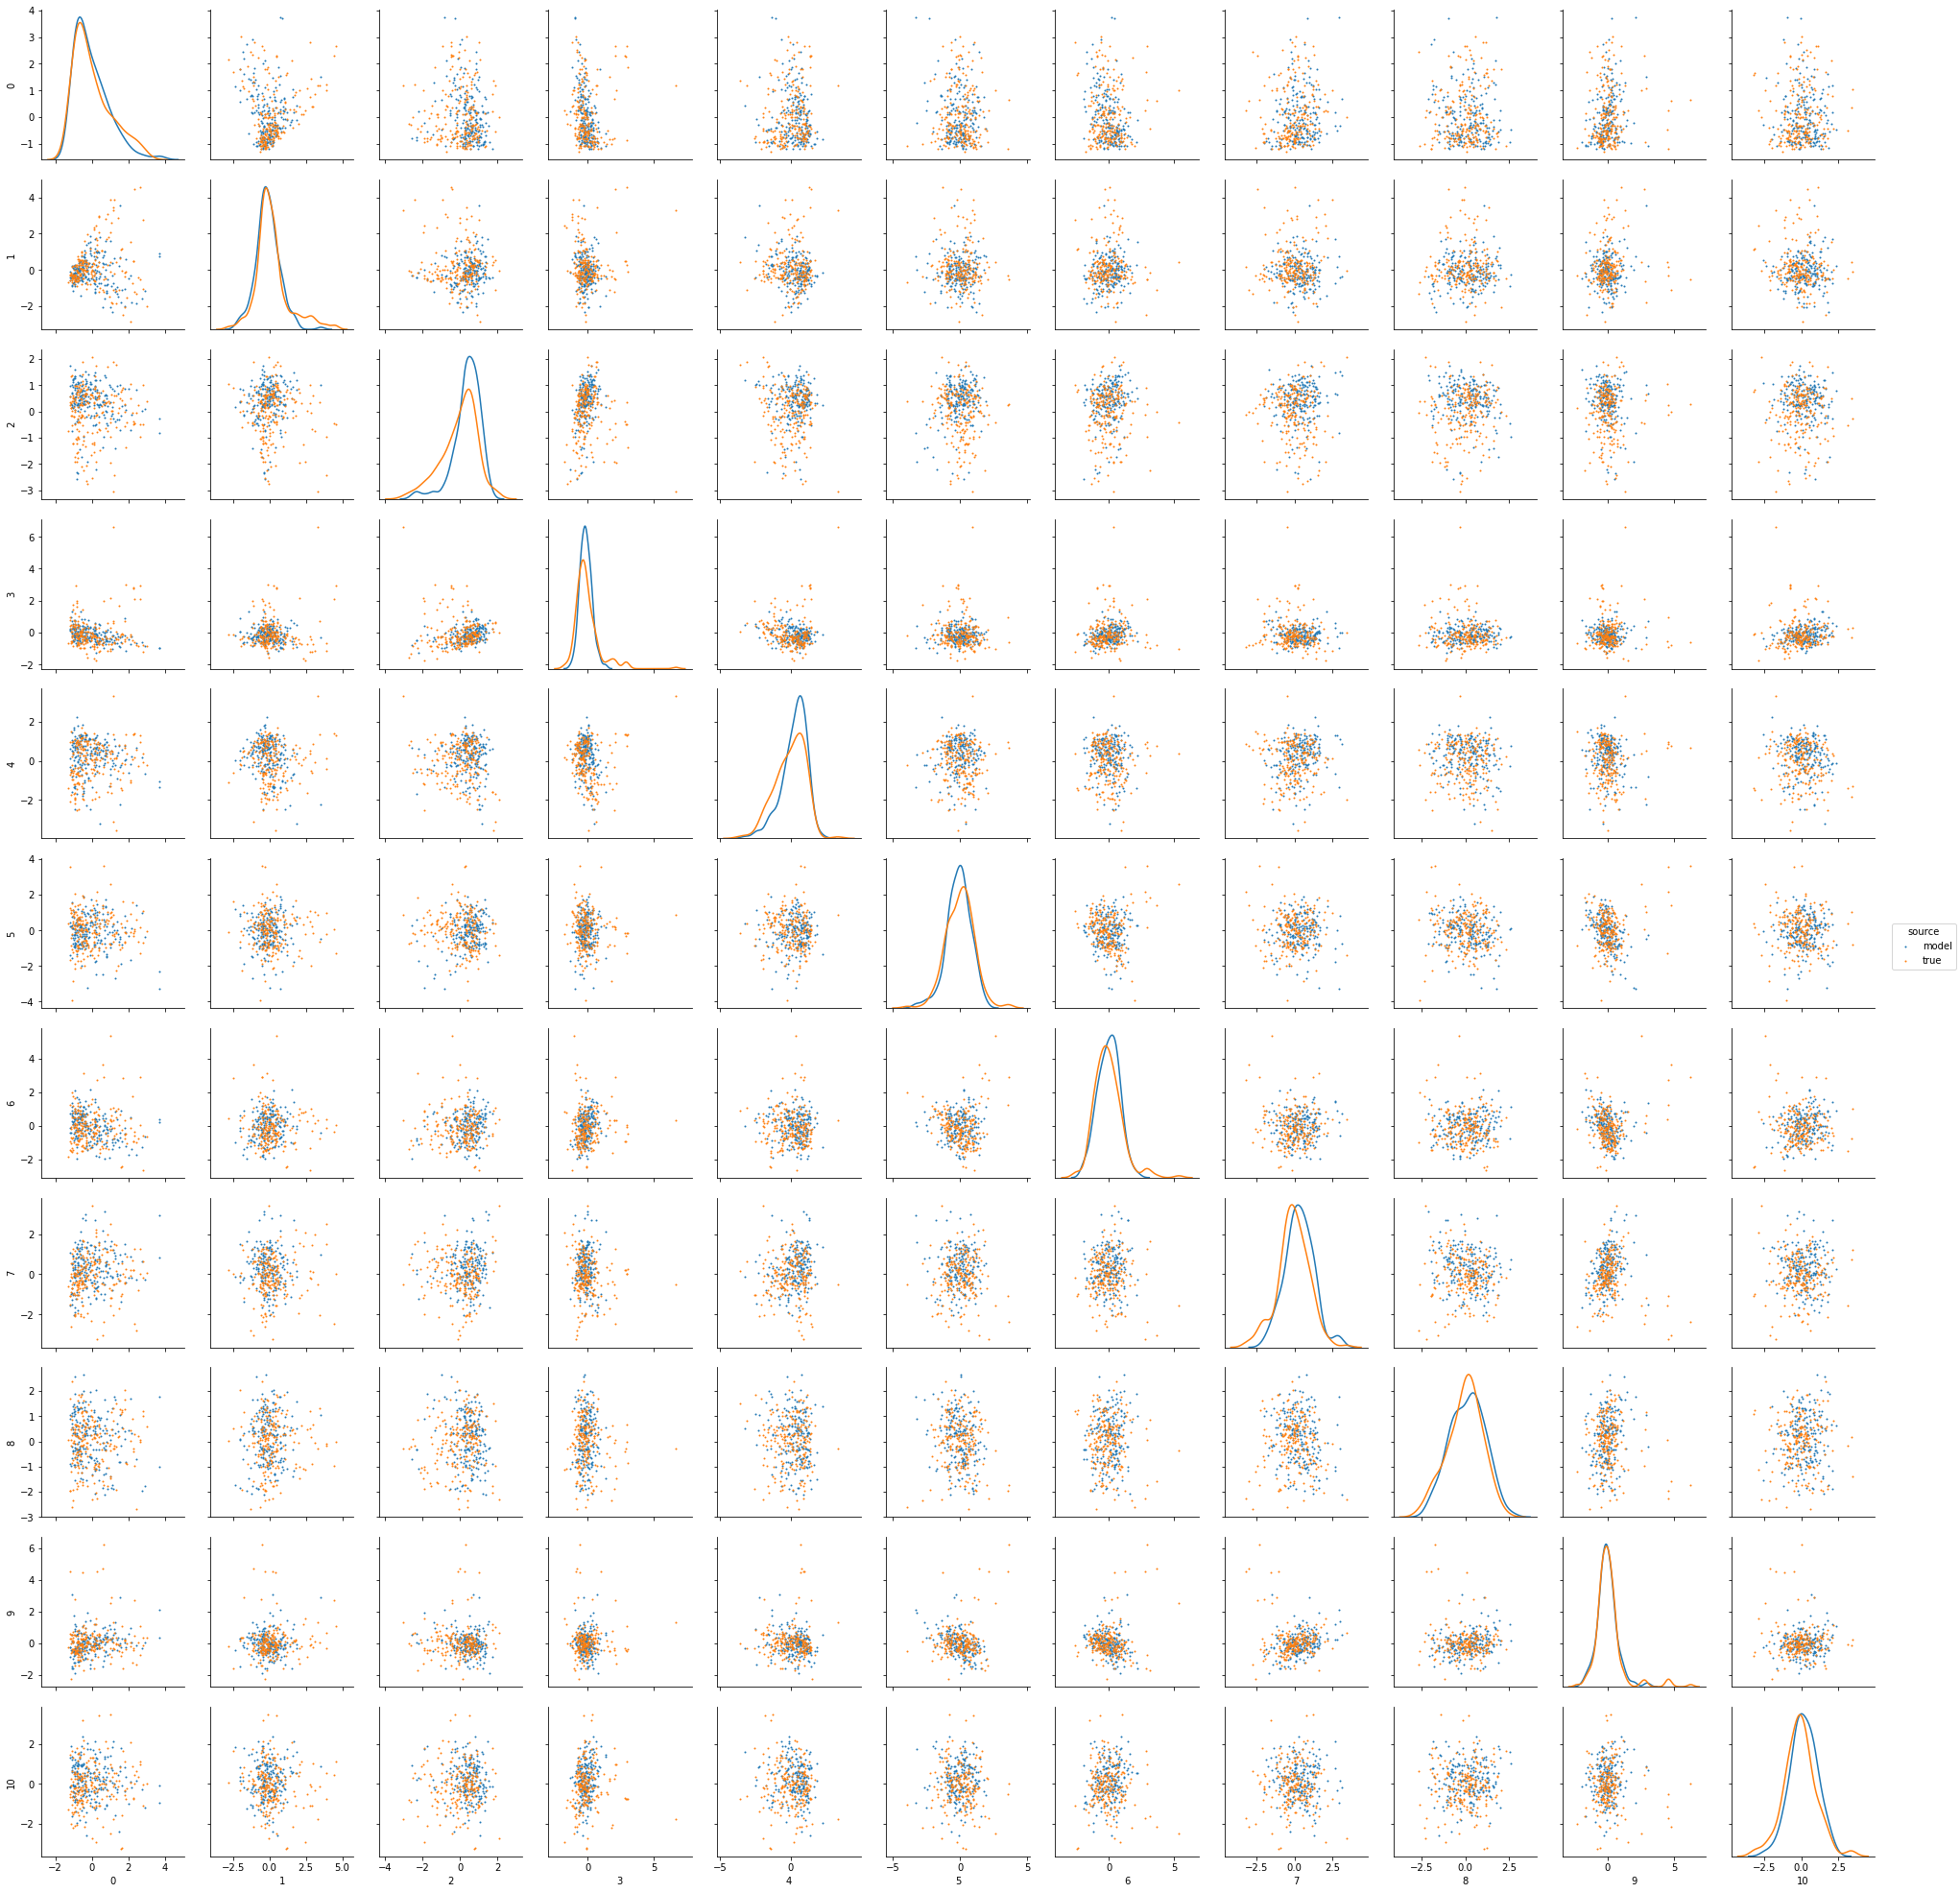

In [53]:
import seaborn as sns
import pandas as pd
perm = np.argsort(p.idx)

model_sample_df = pd.DataFrame(samples[:, :])
model_sample_df["source"] = "model"

true_samples = p.test_data[:nsample]
true_sample_df = pd.DataFrame(true_samples[:, :])
true_sample_df["source"] = "true"

sample_df = pd.concat([model_sample_df, true_sample_df])

fig = sns.pairplot(sample_df, hue="source", size=2.5, diag_kind="kde", kind="scatter",
            plot_kws=dict(s=4, alpha=1.0, linewidth=0),)

#fig.savefig("figs/wine_pairplot.pdf")

# transform maf samples from Gaussian -> generated_data or true_data -> latent 

In [74]:
def plot_samples(x, idx_i, idx_j):
    rn = maf_model.calc_random_numbers(x)
    c = np.arctan2(x[:,0],x[:,1])
    c = c+1.1
    c[c>np.pi]-= 2*np.pi
    c = "r"
    fig, axes = plt.subplots(1,2,figsize=(6,3))

    ax = axes[0]
    ax.scatter(x[:,idx_i], x[:,idx_j], 3, c)
    ax.set_title("data")
    ax = axes[1]
    ax.scatter(rn[:,idx_i], rn[:,idx_j], 3, c)
    ax.set_title("latent")

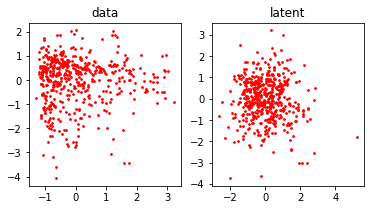

In [75]:
plot_samples(p.test_data, idx_i, idx_j)

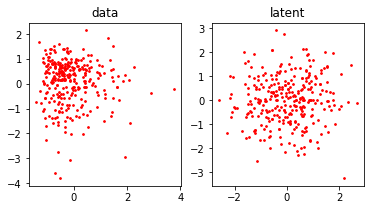

In [77]:
plot_samples(maf_model.gen(300), idx_i, idx_j)

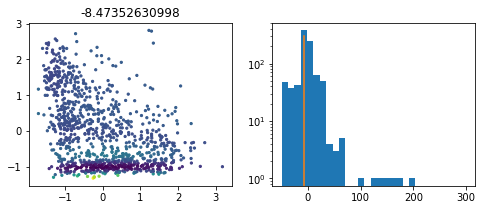

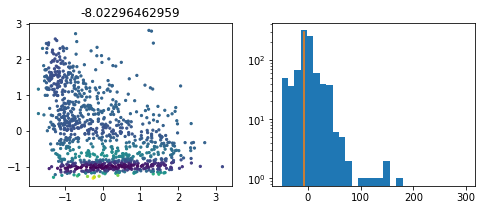

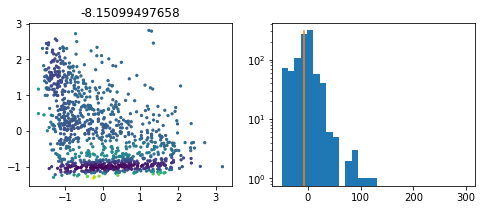

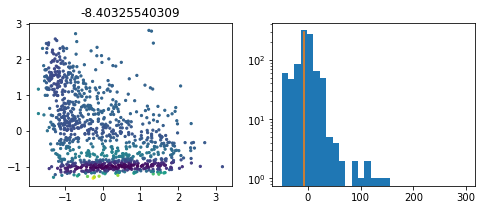

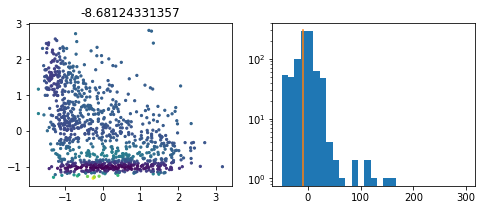

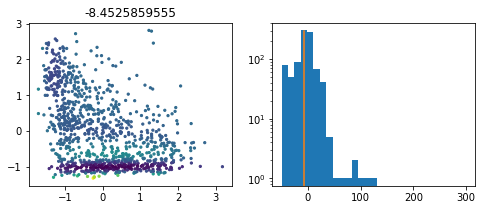

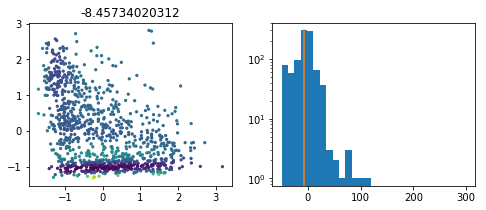

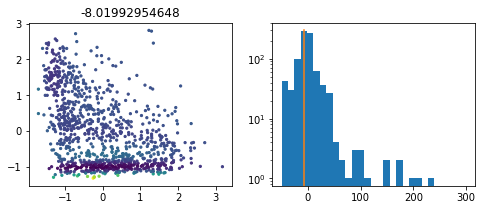

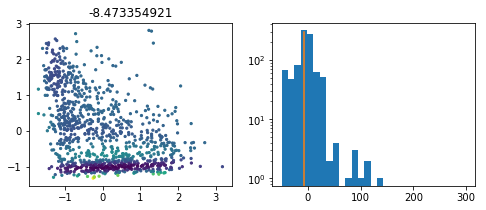

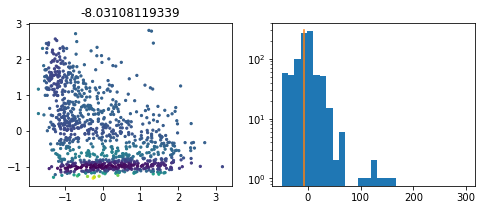

In [22]:
scores = []
logliks = []
for i in range(30):
    
    dl_model.fit_alpha(500)
    sc = dl_model.score_multiple(p.test_data)
    scores.append(sc.mean())
    
    dl_model.logZ = None
    dl_model.estimate_normaliser(n=10**6)
    test_loglik = dl_model.estimate_data_lik(p.test_data, batch_size=p.test_data.shape[0])
    logliks.append(test_loglik/p.ntest)
    
    if i < 10:
        fig, axes = plt.subplots(1,2, figsize=(8,3))

        ax = axes[0]
        ax.scatter(p.test_data[:,0], p.test_data[:,1],5,  sc)
        ax.set_title(sc.mean())

        ax = axes[1]
        ax.hist(sc, log=True, bins=np.linspace(-50,300,30))
        ax.plot([sc.mean(), sc.mean()],[0,300])


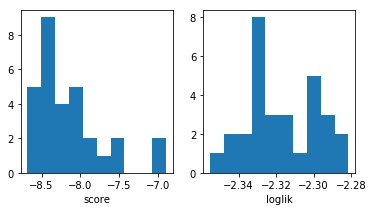

In [29]:
fig, axes = plt.subplots(1,2, figsize=(6,3))
ax = axes[0]
ax.hist(scores)
ax.set_xlabel("score")


ax = axes[1]
ax.hist(logliks)
ax.set_xlabel("loglik")